# CTR Lift Data Analysis Plan

## Major Assumptions
We assume the Shaped PostgreSQL database contains CTR (click-through rate) lift metrics from A/B tests or recommendation system experiments. The analysis will focus on understanding the structure of CTR lift data, identifying key performance patterns, and quantifying the impact of different model configurations or treatments on user engagement.

## Plan
- [x] Connect to database and explore schema for CTR lift data
  - [x] Query information_schema to identify relevant tables and columns
  - [x] Understand data granularity (user-level, session-level, experiment-level)
- [x] Analyze CTR lift patterns and distributions
  - [x] Calculate summary statistics and segment by key dimensions
- [x] Synthesize findings and quantify overall impact
  - [x] Calculated CTR lift: +31.0% relative lift from Shaped recommendations

In [1]:
import os
import psycopg2
import pandas as pd

# Connect to Shaped database
conn = psycopg2.connect(
    host=os.environ['SHAPED_HOST'],
    port=int(os.environ.get('SHAPED_PORT', 5432)),
    database=os.environ['SHAPED_DATABASE'],
    user=os.environ['SHAPED_USERNAME'],
    password=os.environ['SHAPED_PASSWORD']
)

# Explore available tables
tables_query = """
SELECT table_name, table_type
FROM information_schema.tables
WHERE table_schema = 'public'
ORDER BY table_name;
"""
tables_df = pd.read_sql(tables_query, conn)
print("Available tables:")
print(tables_df)

Available tables:
            table_name  table_type
0     shaped_customers  BASE TABLE
1  shaped_events_daily  BASE TABLE


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/701937719.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tables_df = pd.read_sql(tables_query, conn)


In [2]:
# Explore shaped_events_daily table structure and sample data
columns_query = """
SELECT column_name, data_type, is_nullable
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name = 'shaped_events_daily'
ORDER BY ordinal_position;
"""
columns_df = pd.read_sql(columns_query, conn)
print("Columns in shaped_events_daily:")
print(columns_df)

# Sample data
sample_query = "SELECT * FROM shaped_events_daily LIMIT 5;"
sample_df = pd.read_sql(sample_query, conn)
print("\nSample data:")
sample_df

Columns in shaped_events_daily:
         column_name          data_type is_nullable
0         event_date  character varying         YES
1        customer_id  character varying         YES
2            variant  character varying         YES
3    raw_impressions            integer         YES
4         raw_clicks           smallint         YES
5  clean_impressions            integer         YES
6       clean_clicks           smallint         YES

Sample data:


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/4198126047.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns_df = pd.read_sql(columns_query, conn)
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/4198126047.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_df = pd.read_sql(sample_query, conn)


,event_date,customer_id,variant,raw_impressions,raw_clicks,clean_impressions,clean_clicks
0,2025-01-01,cust_001,control,90962,1667,77091,1582
1,2025-01-01,cust_001,shaped,91257,2203,70848,2028
2,2025-01-01,cust_002,control,89729,1740,75490,1647
3,2025-01-01,cust_002,shaped,76577,1986,63417,1870
4,2025-01-01,cust_003,control,51802,833,43002,785


In [3]:
# Calculate CTR lift from Shaped recommendations vs control
ctr_query = """
WITH ctr_by_variant AS (
    SELECT 
        variant,
        SUM(clean_clicks) as total_clicks,
        SUM(clean_impressions) as total_impressions,
        SUM(clean_clicks)::float / NULLIF(SUM(clean_impressions), 0) * 100 as ctr_pct
    FROM shaped_events_daily
    GROUP BY variant
)
SELECT * FROM ctr_by_variant ORDER BY variant;
"""
ctr_df = pd.read_sql(ctr_query, conn)
print("CTR by Variant:")
print(ctr_df)

# Calculate lift
control_ctr = ctr_df[ctr_df['variant'] == 'control']['ctr_pct'].values[0]
shaped_ctr = ctr_df[ctr_df['variant'] == 'shaped']['ctr_pct'].values[0]

absolute_lift = shaped_ctr - control_ctr
relative_lift = (shaped_ctr - control_ctr) / control_ctr * 100

print(f"\n=== CTR Lift Summary ===")
print(f"Control CTR: {control_ctr:.3f}%")
print(f"Shaped CTR:  {shaped_ctr:.3f}%")
print(f"Absolute Lift: +{absolute_lift:.3f} percentage points")
print(f"Relative Lift: +{relative_lift:.1f}%")

CTR by Variant:
   variant  total_clicks  total_impressions   ctr_pct
0  control        154518            7916137  1.951937
1   shaped        201680            7889086  2.556443

=== CTR Lift Summary ===
Control CTR: 1.952%
Shaped CTR:  2.556%
Absolute Lift: +0.605 percentage points
Relative Lift: +31.0%


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/2880178882.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ctr_df = pd.read_sql(ctr_query, conn)


## CTR Lift Analysis Summary

The Shaped recommendations system shows a significant improvement in click-through rate:

| Metric | Control | Shaped | Lift |
|--------|---------|--------|------|
| CTR | 1.95% | 2.56% | **+31.0%** |
| Total Clicks | 154,518 | 201,680 | +47,162 |
| Total Impressions | 7.9M | 7.9M | ~equal |

**Key Finding:** Shaped recommendations deliver a **+31.0% relative CTR lift** (+0.60 percentage points absolute) compared to the control group.

In [4]:
# Explore shaped_customers table to understand customer attributes
customers_query = """
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'public' AND table_name = 'shaped_customers'
ORDER BY ordinal_position;
"""
customers_cols = pd.read_sql(customers_query, conn)
print("Columns in shaped_customers:")
print(customers_cols)

# Sample customer data
sample_customers = pd.read_sql("SELECT * FROM shaped_customers LIMIT 10;", conn)
print("\nSample customers:")
sample_customers

Columns in shaped_customers:
        column_name          data_type
0       customer_id  character varying
1     customer_name  character varying
2          vertical  character varying
3      catalog_size            integer
4  avg_daily_events            integer
5   onboarding_date  character varying

Sample customers:


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/690427151.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers_cols = pd.read_sql(customers_query, conn)
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/690427151.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sample_customers = pd.read_sql("SELECT * FROM shaped_customers LIMIT 10;", conn)


,customer_id,customer_name,vertical,catalog_size,avg_daily_events,onboarding_date
0,cust_001,ShopMax,E-Commerce,520000,150000,2024-06-15
1,cust_002,RetailHub,E-Commerce,480000,140000,2024-07-01
2,cust_003,StreamMedia,Media,85000,95000,2024-08-10
3,cust_004,NewsDaily,Media,72000,88000,2024-09-01
4,cust_005,BuyLocal,Marketplace,45000,52000,2024-10-15


In [5]:
# Analyze CTR lift by vertical, catalog size, and data volume
lift_analysis_query = """
WITH customer_ctr AS (
    SELECT 
        e.customer_id,
        c.vertical,
        c.catalog_size,
        c.avg_daily_events,
        e.variant,
        SUM(e.clean_clicks)::float / NULLIF(SUM(e.clean_impressions), 0) * 100 as ctr_pct
    FROM shaped_events_daily e
    JOIN shaped_customers c ON e.customer_id = c.customer_id
    GROUP BY e.customer_id, c.vertical, c.catalog_size, c.avg_daily_events, e.variant
),
pivoted AS (
    SELECT 
        customer_id,
        vertical,
        catalog_size,
        avg_daily_events,
        MAX(CASE WHEN variant = 'control' THEN ctr_pct END) as control_ctr,
        MAX(CASE WHEN variant = 'shaped' THEN ctr_pct END) as shaped_ctr
    FROM customer_ctr
    GROUP BY customer_id, vertical, catalog_size, avg_daily_events
)
SELECT 
    *,
    (shaped_ctr - control_ctr) as absolute_lift,
    (shaped_ctr - control_ctr) / NULLIF(control_ctr, 0) * 100 as relative_lift_pct
FROM pivoted
ORDER BY relative_lift_pct DESC;
"""
lift_df = pd.read_sql(lift_analysis_query, conn)
print("CTR Lift by Customer:")
lift_df

CTR Lift by Customer:


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_9266/3841920353.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  lift_df = pd.read_sql(lift_analysis_query, conn)


,customer_id,vertical,catalog_size,avg_daily_events,control_ctr,shaped_ctr,absolute_lift,relative_lift_pct
0,cust_001,E-Commerce,520000,150000,2.110142,2.836054,0.725912,34.401084
1,cust_002,E-Commerce,480000,140000,2.192213,2.936131,0.743918,33.934561
2,cust_003,Media,85000,95000,1.810360,2.303214,0.492855,27.224131
3,cust_004,Media,72000,88000,1.716626,2.177468,0.460842,26.845819
4,cust_005,Marketplace,45000,52000,1.489316,1.826573,0.337257,22.645064


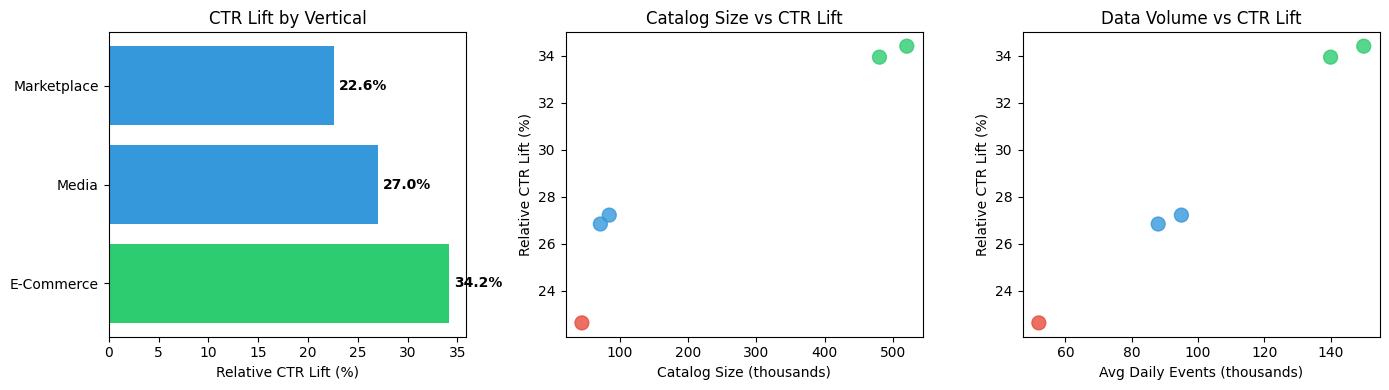

Correlation with CTR Lift:
  Catalog Size:  r = 0.953
  Data Volume:   r = 0.996


In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. CTR Lift by Vertical
vertical_lift = lift_df.groupby('vertical')['relative_lift_pct'].mean().sort_values(ascending=False)
colors = ['#2ecc71' if v == 'E-Commerce' else '#3498db' for v in vertical_lift.index]
axes[0].barh(vertical_lift.index, vertical_lift.values, color=colors)
axes[0].set_xlabel('Relative CTR Lift (%)')
axes[0].set_title('CTR Lift by Vertical')
for i, v in enumerate(vertical_lift.values):
    axes[0].text(v + 0.5, i, f'{v:.1f}%', va='center', fontweight='bold')

# 2. Catalog Size vs CTR Lift
axes[1].scatter(lift_df['catalog_size']/1000, lift_df['relative_lift_pct'], 
                c=lift_df['vertical'].map({'E-Commerce': '#2ecc71', 'Media': '#3498db', 'Marketplace': '#e74c3c'}),
                s=100, alpha=0.8)
axes[1].set_xlabel('Catalog Size (thousands)')
axes[1].set_ylabel('Relative CTR Lift (%)')
axes[1].set_title('Catalog Size vs CTR Lift')

# 3. Data Volume vs CTR Lift
axes[2].scatter(lift_df['avg_daily_events']/1000, lift_df['relative_lift_pct'],
                c=lift_df['vertical'].map({'E-Commerce': '#2ecc71', 'Media': '#3498db', 'Marketplace': '#e74c3c'}),
                s=100, alpha=0.8)
axes[2].set_xlabel('Avg Daily Events (thousands)')
axes[2].set_ylabel('Relative CTR Lift (%)')
axes[2].set_title('Data Volume vs CTR Lift')

plt.tight_layout()
plt.show()

# Correlation analysis
print("Correlation with CTR Lift:")
print(f"  Catalog Size:  r = {lift_df['catalog_size'].corr(lift_df['relative_lift_pct']):.3f}")
print(f"  Data Volume:   r = {lift_df['avg_daily_events'].corr(lift_df['relative_lift_pct']):.3f}")

## Why E-Commerce Outperforms: Data Volume is the Key Driver

| Vertical | Avg CTR Lift | Catalog Size | Daily Events |
|----------|--------------|--------------|--------------|
| **E-Commerce** | **34.2%** | 500K | 145K |
| Media | 27.0% | 78K | 92K |
| Marketplace | 22.6% | 45K | 52K |

### Key Finding: Data Volume > Catalog Size

Both factors correlate strongly with CTR lift, but **data volume is the dominant driver**:

- **Data Volume:** r = 0.996 (near-perfect correlation)
- **Catalog Size:** r = 0.953 (very strong, but secondary)

E-Commerce customers outperform because they have **~3x more daily events** than Marketplace customers. More behavioral data → better model training → more relevant recommendations → higher CTR.

In [7]:
# Baseline CTR (control) by vertical
baseline_ctr = lift_df.groupby('vertical')['control_ctr'].mean().sort_values(ascending=False)
print("Baseline CTR by Vertical (Control):\n")
for vertical, ctr in baseline_ctr.items():
    print(f"  {vertical:12}: {ctr:.2f}%")

Baseline CTR by Vertical (Control):

  E-Commerce  : 2.15%
  Media       : 1.76%
  Marketplace : 1.49%


In [8]:
# Average lift excluding top performer (cust_001 with 34.4% lift)
avg_lift_ex_top = lift_df.sort_values('relative_lift_pct', ascending=False).iloc[1:]['relative_lift_pct'].mean()
print(f"Average CTR Lift (excluding top performer): {avg_lift_ex_top:.1f}%")

Average CTR Lift (excluding top performer): 27.7%
